# Plotting basics for plotting spectral stacks

In [1]:
##Set up matplotlib for display in the browser:
%matplotlib inline
# Next we make sure the plots are high-res:
import matplotlib as mpl
mpl.rc("savefig", dpi=150)

In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
import glob

from astropy.io import fits
from astropy.io import ascii


##Automatic unit tracking + constants
import astropy.units as u
import astropy.constants as c

## Basic multi-panel plots:

#### Approach 1:
Here is one approach to making multi-panel plots. It makes 4 subplots with shared x, y axes.

<Figure size 288x720 with 0 Axes>

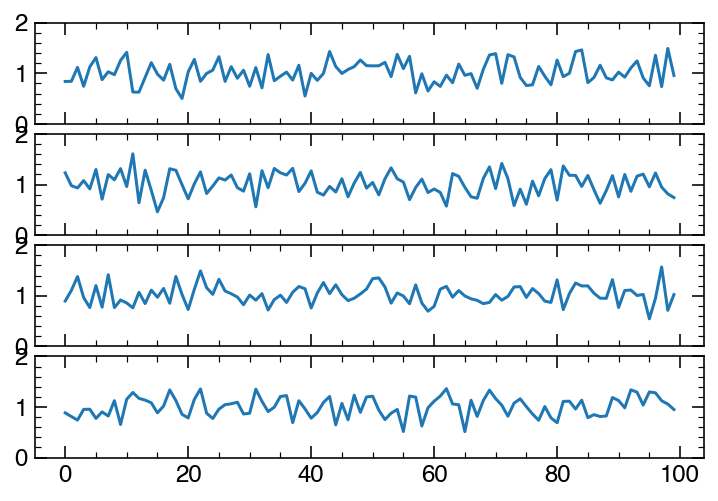

In [2]:
x=np.arange(100)

## Start the figure:
plt.figure(figsize=(4,10))
figx, (ax1, ax2, ax3,ax4) = plt.subplots(4, sharex=True,sharey=True)

ax1.plot(x, np.random.normal(loc=1,scale=0.2,size=len(x)))
#ax1.set_xlim([0,2])
ax1.set_ylim([0,2])

ax2.plot(x, np.random.normal(loc=1,scale=0.2,size=len(x)))
ax3.plot(x, np.random.normal(loc=1,scale=0.2,size=len(x)))
ax4.plot(x,np.random.normal(loc=1,scale=0.2,size=len(x)))
# Fine-tune figure; make subplots close to each other and hide x ticks for
#   all but bottom plot.
figx.subplots_adjust(hspace=0.1)

A slightly different approach is given below.

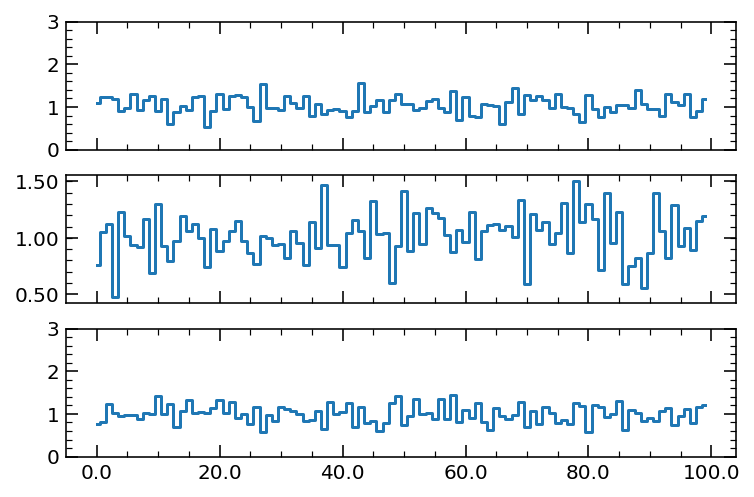

In [4]:
ax1 = plt.subplot(311)
plt.plot(x,np.random.normal(loc=1,scale=0.2,size=len(x)),drawstyle='steps-mid')
# make these tick labels invisible
plt.setp(ax1.get_xticklabels(), visible=False)

# Share x axis parameters only
ax2 = plt.subplot(312, sharex=ax1)
plt.plot(x,np.random.normal(loc=1,scale=0.2,size=len(x)),drawstyle='steps-mid')
# make these tick labels invisible
plt.setp(ax2.get_xticklabels(), visible=False)

# Share x and y axis parameters
ax3 = plt.subplot(313, sharex=ax1, sharey=ax1)
plt.plot(x,np.random.normal(loc=1,scale=0.2,size=len(x)),drawstyle='steps-mid')
#Notice when we change the y-axis limits, it affects ax1+ax3, but not ax2
ax3.set_ylim(0,3)

## Let's monkey with the format of the labels:
import matplotlib.ticker as ticker
ax3.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%1.2f'))

# Plotting GBT spectra

As an example, we'll plot a few GBT spectra from Project AMIGA GBT. 

### Read in the spectra:

First we need to define where to look for the data.

In [5]:
dataDir = 'Data/'

The first step is to create some labels to report the column densities. The names will be used to construct filenames, as well.

In [6]:
qsoname1 = 'KAZ238'
label1 = r'$\mathregular{log \, N(H I) \leq 17.57 \, (5\sigma)}$'

qsoname2 = 'RXSJ0155.6+3115'
label2 = r'$\mathregular{log \, N(H I) \leq 17.39 \, (5\sigma)}$'

qsoname3 = 'RBS2055'
label3 = r'$\mathregular{log \, N(H I) = 18.08\pm0.06}$'

qsoname4 = 'RBS2061'
label4 = r'$\mathregular{log \, N(H I) = 18.18\pm0.07}$'

Next we set up the filenames.

In [7]:
gbtFile1=dataDir+'spec-'+qsoname1+'.dat'
gbtFile2=dataDir+'spec-'+qsoname2+'.dat'
gbtFile3=dataDir+'spec-'+qsoname3+'.dat'
gbtFile4=dataDir+'spec-'+qsoname4+'.dat'

#### Read the data with `ascii.read`
We use the read functionality of the `astropy.ascii` module. Our data are a bit goofy. The header looks like the following:
```
Scan:     10           KAZ238 2015-10-21 +00 08 17.0
          RADIO                  Ta*   
        km/s-BAR                 XX
   -529.1251206491930361     -0.0094445
   ...
```

Because of this we have to use `data_start=3` to tell it to start looking for the spectra on line 3 (first line is line 0).

In [8]:
spec1 = ascii.read(gbtFile1,data_start=3,names=['vlsr','Ta'])
spec2 = ascii.read(gbtFile2,data_start=3,names=['vlsr','Ta'])
spec3 = ascii.read(gbtFile3,data_start=3,names=['vlsr','Ta'])
spec4 = ascii.read(gbtFile4,data_start=3,names=['vlsr','Ta'])

### Plot parameters:
Here we define some quantities to get the data scaling, plot boundaries, and plot labels correct.

In [9]:
#Get the scale right. This combines main beam efficiency and unit transformation to mK.
eff_mb = 0.88*1.e-3 ## Effic. & conversion to mK

##Set up the plotting variables:

#Boundaries of the plots
xbounds = [-515,-140]
ybounds = [-15,50]
ystepsize = 20.

#Positions of text labels
xTextPos = xbounds[1]-10.
xTextPos2 = xbounds[0]+20.
yTextPos = ybounds[1]*0.85

#Axis labels
xlabelText = r'$\mathregular{v_{LSR} \ [km/s]}$'
ylabelText = r'$\mathregular{T_b \  [mK]}$'

### Do the plots:

A few things of note for spectra:
* We use `drawstyle="steps-mid"` to get the histogram-style plots.
* We make use of the `sharex, sharey` options in the `plt.subplot` step to force all to have the same x and y axis limits.
* After sharing x and y axes, we set their ranges in a single step at the end.
* `plt.text()` is the equivalent of IDL's `xyouts` command.
* The approach below to inserting the zero flux level works so long as our initial x limits are broader than what follows.

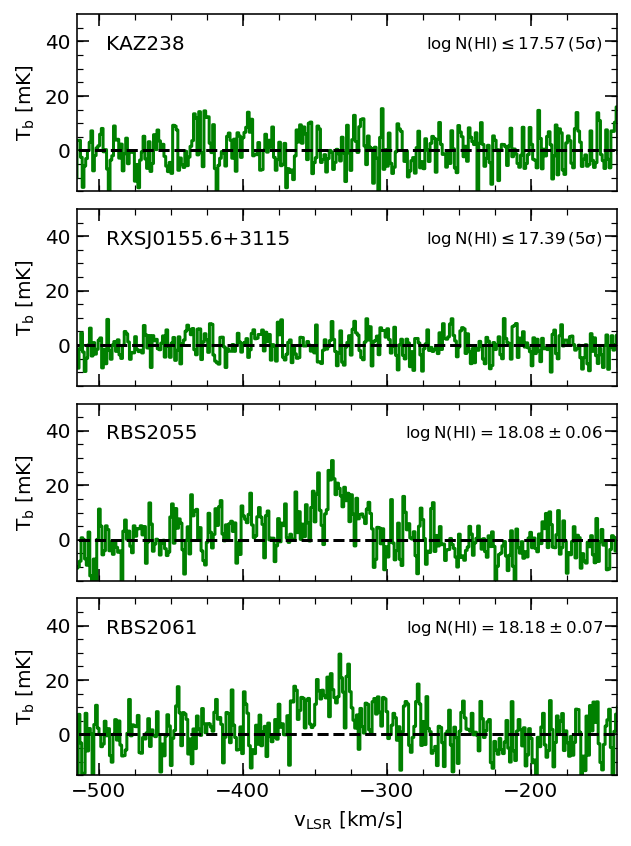

In [10]:
# Initiate the plot. This sets the size of the figure (and its relative dimensions)
plt.figure(figsize=(5,7))

##########
#Plot 1
#First initialize the subplot, telling Python we want 
#  a set of figures across 4 rows, 1 column, and we're on the 1st plot:
ax1 = plt.subplot(411)

#Do the actual plotting:
plt.plot(spec1['vlsr'],spec1['Ta']/eff_mb,color='g',
         drawstyle='steps-mid',label=qsoname1)
# Plot a dashed line at 0 flux. Here "k"=black, "--" = dashed. 
#   **This particular approach only works as long as our x limits aren't 
#    ever broader than their initial values.
plt.plot(ax1.get_xbound(),np.zeros(2),'k--')
##  Alternatively, use:
#plt.plot(spec1['vlsr'],np.zeros_like(spec1['vlsr']),'k--')

# Make these tick labels invisible. We only use this for the first 3 plots
plt.setp(ax1.get_xticklabels(), visible=False)
#Add the y-axis label
ax1.set_ylabel(ylabelText)

#Add the QSO name and H I column density information:
ax1text=plt.text(xTextPos, yTextPos,label1,size='small',
                 horizontalalignment='right',
                 verticalalignment='top')

ax1text=plt.text(xTextPos2, yTextPos,qsoname1,
                 horizontalalignment='left',
                 verticalalignment='top')


##########
#Plot 2
ax2 = plt.subplot(412, sharex=ax1, sharey=ax1)
plt.plot(spec2['vlsr'],spec2['Ta']/eff_mb,color='g',
         drawstyle='steps-mid',label=qsoname2)
## Here's our alternative zero plotter:
plt.plot(spec2['vlsr'],np.zeros_like(spec2['vlsr']),'k--')
# make these tick labels invisible
plt.setp(ax2.get_xticklabels(), visible=False)
ax2.set_ylabel(ylabelText)
ax2text=plt.text(xTextPos, yTextPos,label2,size='small',
                 horizontalalignment='right',
                 verticalalignment='top')
ax2text=plt.text(xTextPos2, yTextPos,qsoname2,
                 horizontalalignment='left',
                 verticalalignment='top')


##########
#Plot 3
ax3 = plt.subplot(413, sharex=ax1, sharey=ax1)
plt.plot(spec3['vlsr'],spec3['Ta']/eff_mb,color='g',
         drawstyle='steps-mid',label=qsoname3)
plt.plot(ax2.get_xbound(),np.zeros(2),'k--')
# make these tick labels invisible
plt.setp(ax3.get_xticklabels(), visible=False)
ax3.set_ylabel(ylabelText)
ax3text=plt.text(xTextPos, yTextPos,label3,size='small',
                 horizontalalignment='right',
                 verticalalignment='top')
ax3text=plt.text(xTextPos2, yTextPos,qsoname3,
                 horizontalalignment='left',
                 verticalalignment='top')


##########
#Plot 4
ax4 = plt.subplot(414, sharex=ax1, sharey=ax1)
plt.plot(spec4['vlsr'],spec4['Ta']/eff_mb,color='g',
         drawstyle='steps-mid',label=qsoname4)
plt.plot(ax2.get_xbound(),np.zeros(2),'k--')
ax4text=plt.text(xTextPos, yTextPos,label4,size='small',
                 horizontalalignment='right',
                 verticalalignment='top')
ax4text=plt.text(xTextPos2, yTextPos,qsoname4,
                 horizontalalignment='left',
                 verticalalignment='top')


# Set the limits in x,y
ax4.set_xlim(xbounds)
ax4.set_ylim(ybounds)
ax4.set_xlabel(xlabelText)
ax4.set_ylabel(ylabelText)

### We need to get the ticks correct
# Set the y-ticks in steps of 20 mK
ax4.set_yticks(np.arange(0,60, 20))
# Plot minor ticks on y axis
ax4.set_yticks(np.arange(ybounds[0],ybounds[1], 5),minor=True)
# Set the x-ticks in steps of 100 km/s
ax4.set_xticks(np.arange(-500,-150,100))
# Plot minor ticks on x axis
ax4.set_xticks(np.arange(-500,-150,25),minor=True)

##Squeeze the plots together, make space for y-axis labels (why is this needed??):
plt.subplots_adjust(hspace=0.1,left=0.15)

## Save the plots to a PDF file:
plt.savefig('fig-gbtSpectra.pdf')

### Saving the plots

Notice the last line of the code above. Saving the plots is a pretty automated part of this approach, and the file type is set by the suffix attached to the filename (try PNG,JPEG,EPS, etc.)

The code is here for posterity (but won't save the figure above because it is a separate instance of `plt` within the iPyNB).

```
plt.savefig('fig-gbtSpectra.pdf')
```